In [2]:
import os
import cv2
import math
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.applications.mobilenet_v2 import MobileNetV2

from IPython.display import HTML
from base64 import b64encode

E0000 00:00:1720930329.413750      13 common_lib.cc:815] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`=local.
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:531


In [3]:
def Play_Video(filepath):
    html = ''
    video = open(filepath, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [4]:
NonViolnceVideos_Dir = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/"
ViolnceVideos_Dir = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/"

In [5]:
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

In [6]:
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [7]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

In [8]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

In [9]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 15

In [10]:
DATASET_DIR = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/"

In [11]:
CLASSES_LIST = ["NonViolence", "Violence"]

In [12]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [13]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [14]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: NonViolence


[h264 @ 0x57bedc4e0ac0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x57bedc4e0ac0] error while decoding MB 98 31
[h264 @ 0x57bedba2e140] mb_type 104 in P slice too large at 98 31
[h264 @ 0x57bedba2e140] error while decoding MB 98 31
[h264 @ 0x57bedba2e140] mb_type 104 in P slice too large at 98 31
[h264 @ 0x57bedba2e140] error while decoding MB 98 31
[h264 @ 0x57bedba2e140] mb_type 104 in P slice too large at 98 31
[h264 @ 0x57bedba2e140] error while decoding MB 98 31
[h264 @ 0x57bedba2e140] mb_type 104 in P slice too large at 98 31
[h264 @ 0x57bedba2e140] error while decoding MB 98 31


Extracting Data of Class: Violence


In [15]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.2,
                                                                            shuffle=True, random_state=42)

In [16]:
print(features_train.shape, labels_train.shape)
print(features_test.shape, labels_test.shape)

(1600, 15, 64, 64, 3) (1600, 2)
(400, 15, 64, 64, 3) (400, 2)


In [17]:
mobilenet = MobileNetV2(include_top=False, weights="imagenet")
mobilenet.trainable = True

2024-07-14 04:19:51.613355: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-07-14 04:19:51.613462: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-07-14 04:19:51.613553: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-07-14 04:19:51.613644: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-07-14 04:19:51.613722: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-07-14 04:19:51.613917: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-07-14 04:19:51.614000: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

9406464/9406464 [==============================] - 1s 0us/step


In [36]:
for layer in mobilenet.layers[:-30]:
    layer.trainable = False

In [35]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(mobilenet))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards=True)
    model.add(Bidirectional(lstm_fw, backward_layer=lstm_bw))

    model.add(Dropout(0.25))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()
    return model

In [41]:
MoBiLSTM_model = create_model()
plot_model(MoBiLSTM_model, to_file='MobBiLSTM_model_structure_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDi  (None, 15, 2, 2, 1280)    2257984   
 stributed)                                                      
                                                                 
 dropout_15 (Dropout)        (None, 15, 2, 2, 1280)    0         
                                                                 
 time_distributed_7 (TimeDi  (None, 15, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                1319168   
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                      

In [43]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=0.00005, verbose=1)

In [44]:
MoBiLSTM_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])
MobBiLSTM_model_history = MoBiLSTM_model.fit(x=features_train, y=labels_train, epochs=40, batch_size=8,
                                             shuffle=True, validation_split=0.2,
                                             callbacks=[early_stopping_callback, reduce_lr])


Epoch 1/40
160/160 [==============================] - 35s 183ms/step - loss: 0.4870 - accuracy: 0.7750 - val_loss: 0.2971 - val_accuracy: 0.8938 - lr: 0.0100
Epoch 2/40
160/160 [==============================] - 27s 168ms/step - loss: 0.2827 - accuracy: 0.9000 - val_loss: 0.2573 - val_accuracy: 0.8969 - lr: 0.0100
Epoch 3/40
160/160 [==============================] - 26s 165ms/step - loss: 0.1911 - accuracy: 0.9359 - val_loss: 0.2549 - val_accuracy: 0.9250 - lr: 0.0100
Epoch 4/40
160/160 [==============================] - 26s 165ms/step - loss: 0.1710 - accuracy: 0.9469 - val_loss: 0.2444 - val_accuracy: 0.9219 - lr: 0.0100
Epoch 5/40
160/160 [==============================] - 26s 166ms/step - loss: 0.1564 - accuracy: 0.9523 - val_loss: 0.2037 - val_accuracy: 0.9312 - lr: 0.0100
Epoch 6/40
160/160 [==============================] - 26s 165ms/step - loss: 0.1171 - accuracy: 0.9617 - val_loss: 0.2470 - val_accuracy: 0.9187 - lr: 0.0100
Epoch 7/40
160/160 [==============================] 

In [23]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

13/13 [==============================] - 6s 314ms/step - loss: 0.2442 - accuracy: 0.9300


In [24]:
MoBiLSTM_model.save("Violence_Detection.h5")

/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
def plot_metrics(model_training_history, metric_name_1, metric_name_2, plot_name):
    value_1 = model_training_history.history[metric_name_1]
    value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

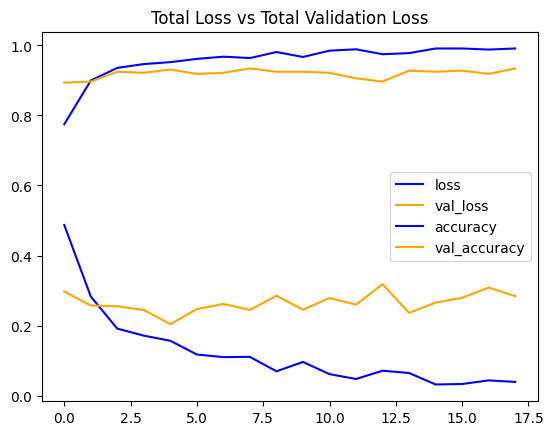

In [49]:
import plot_metric

plot_metrics(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_metrics(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [28]:
import pickle 
pickle_out = open("violence_detection.pkl", "wb") 
pickle.dump(MoBiLSTM_model, pickle_out) 
pickle_out.close()